In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import DataLoader, Dataset

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
torch.set_grad_enabled(True)

Using device: cuda


In [35]:
text_data = [
    "I am completing my MATH assignment.",
    "John is working on his science project.",
    "Alice is not doing her history homework.",
    "Mark is finishing his English essay.",
    "Sara is studying for her biology test.",
    "Emma is preparing her presentation on physics.",
    "Tom is writing his computer science report.",
    "Lucy is reading a book on chemistry."
]

# Tokenize text data into characters
vocab = sorted(set(''.join(text_data)))  
vocab_size = len(vocab)
char_to_idx = {char: idx for idx, char in enumerate(vocab)}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}
encoded_data = [[char_to_idx[char] for char in sentence] for sentence in text_data]
max_len = max(len(seq) for seq in encoded_data)
padded_data = [seq + [0] * (max_len - len(seq)) for seq in encoded_data]
padded_data = np.array(padded_data)
input_data = torch.tensor(padded_data, dtype=torch.long, device=device)


In [36]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, sparsity_param=0.05, beta=3):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        )
        self.sparsity_param = sparsity_param
        self.beta = beta

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

    def kl_divergence(self, p, q):
        """Calculate the Kullback-Leibler divergence for the sparsity constraint."""
        return p * torch.log(p / q) + (1 - p) * torch.log((1 - p) / (1 - q))

    def sparse_loss(self, encoded):
        """Calculate the sparsity loss."""
        rho_hat = torch.mean(encoded, dim=0)
        rho = torch.full_like(rho_hat, self.sparsity_param)
        kl_div = self.kl_divergence(rho, rho_hat)
        return self.beta * torch.sum(kl_div)

In [37]:
input_size = max_len * vocab_size
hidden_size = 32
learning_rate = 0.001
num_epochs = 100

# Initialize the model, loss function, and optimizer
model = SparseAutoencoder(input_size, hidden_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# One-hot encode input data
onehot_encoder = OneHotEncoder(categories=[range(vocab_size)] * max_len, sparse_output=False)
input_data_onehot = onehot_encoder.fit_transform(input_data.cpu().numpy())
input_data_onehot = torch.tensor(input_data_onehot, dtype=torch.float32, device=device)

# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()
    encoded, decoded = model(input_data_onehot)
    loss = criterion(decoded, input_data_onehot)
    sparsity_loss = model.sparse_loss(encoded)
    total_loss = loss + sparsity_loss
    total_loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss.item():.4f}, Sparsity Loss: {sparsity_loss.item():.4f}")

Epoch [10/100], Loss: inf, Sparsity Loss: inf
Epoch [20/100], Loss: inf, Sparsity Loss: inf
Epoch [30/100], Loss: inf, Sparsity Loss: inf
Epoch [40/100], Loss: inf, Sparsity Loss: inf
Epoch [50/100], Loss: inf, Sparsity Loss: inf
Epoch [60/100], Loss: inf, Sparsity Loss: inf
Epoch [70/100], Loss: inf, Sparsity Loss: inf
Epoch [80/100], Loss: inf, Sparsity Loss: inf
Epoch [90/100], Loss: inf, Sparsity Loss: inf
Epoch [100/100], Loss: inf, Sparsity Loss: inf


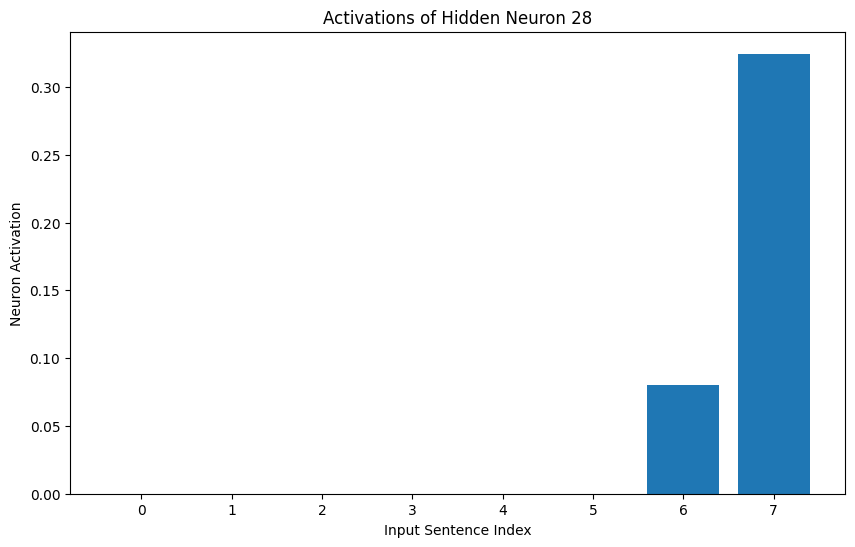

Sentences that highly activate neuron 28:
Top 2 activation sentences for neuron 28
Sentence 7: 'Tom is writing his computer science report.' (Activation: 0.0800)
Sentence 8: 'Lucy is reading a book on chemistry.' (Activation: 0.3245)


In [45]:
encoded_data, _ = model(input_data_onehot)

# Find an interesting neuron/feature
neuron_index = 28  
neuron_activations = encoded_data[:, neuron_index].detach().cpu().numpy()

# Visualize the activations
plt.figure(figsize=(10, 6))
plt.bar(range(len(neuron_activations)), neuron_activations)
plt.xlabel("Input Sentence Index")
plt.ylabel("Neuron Activation")
plt.title(f"Activations of Hidden Neuron {neuron_index}")
plt.show()

activation_threshold = 0.5  
print(f"Sentences that highly activate neuron {neuron_index}:")
for i, activation in enumerate(neuron_activations):
    if activation > activation_threshold:
        print(f"Sentence {i+1}: {text_data[i]} (Activation: {activation:.4f})")

top_indices = np.argsort(neuron_activations)[-2:]
print("Top 2 activation sentences for neuron", neuron_index)
for idx in top_indices:
    print(f"Sentence {idx+1}: '{text_data[idx]}' (Activation: {neuron_activations[idx]:.4f})")

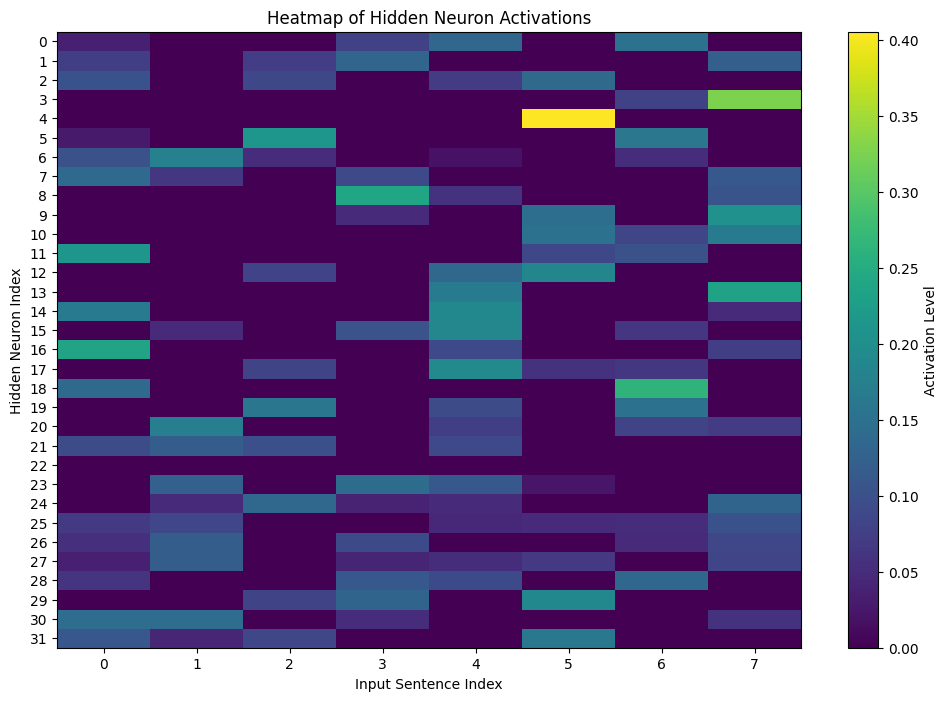

In [46]:
def capture_activations(input_data):
    """Function to compute the activations of the hidden layer."""
    with torch.no_grad():
        encoded_data, _ = model(input_data)
    return encoded_data

# Capture activations for input data
activations = capture_activations(input_data_onehot)

# Visualize the activations as a heatmap
plt.figure(figsize=(12, 8))
plt.imshow(activations.detach().cpu().numpy().T, cmap='viridis', aspect='auto')
plt.colorbar(label='Activation Level')
plt.xlabel('Input Sentence Index')
plt.ylabel('Hidden Neuron Index')
plt.title('Heatmap of Hidden Neuron Activations')
plt.gca().invert_yaxis()
plt.yticks(ticks=np.arange(activations.shape[1]), labels=np.arange(activations.shape[1])[::-1])
plt.show()

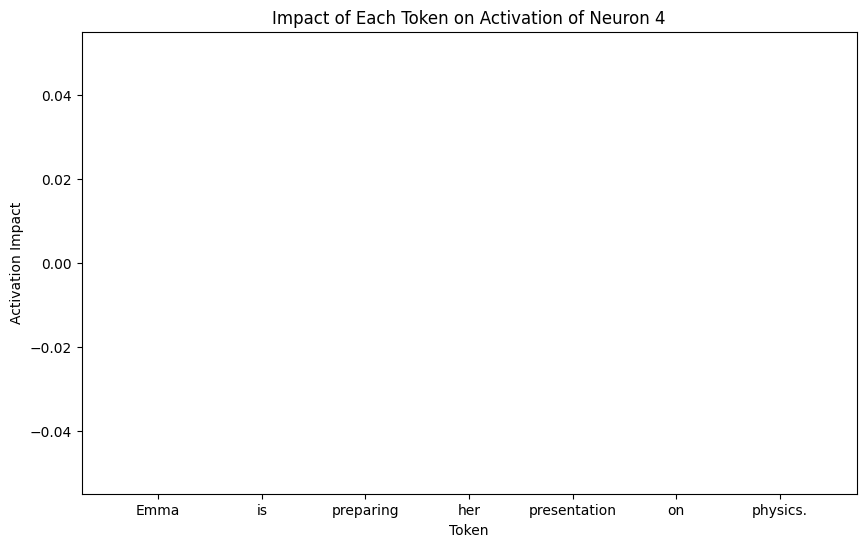

Token: Emma, Impact on Activation: 0.0000
Token: is, Impact on Activation: 0.0000
Token: preparing, Impact on Activation: 0.0000
Token: her, Impact on Activation: 0.0000
Token: presentation, Impact on Activation: 0.0000
Token: on, Impact on Activation: 0.0000
Token: physics., Impact on Activation: 0.0000


In [67]:
# Prepare the one-hot encoder
def prepare_onehot_encoder(vocab, max_len):
    extended_vocab = vocab + ["<UNK>", "<PAD>"]
    onehot_encoder = OneHotEncoder(categories=[extended_vocab] * max_len, sparse_output=False, handle_unknown='ignore')
    onehot_encoder.fit([["<PAD>"] * max_len])  # Fit with a padded sample to set the correct shape
    return onehot_encoder

# Function to encode sentences
def encode_sentence(sentence, onehot_encoder, max_len, vocab_set):
    tokens = sentence.split()
    tokens = pad_or_truncate(tokens, max_len)
    tokens = [token if token in vocab_set else "<UNK>" for token in tokens]
    return onehot_encoder.transform([tokens])

# Function to pad or truncate the sentences to match max_len
def pad_or_truncate(sentence_tokens, max_len):
    if len(sentence_tokens) < max_len:
        return sentence_tokens + ["<PAD>"] * (max_len - len(sentence_tokens))
    else:
        return sentence_tokens[:max_len]

# Function to analyze per-token impact on neuron activation
def analyze_per_token_impact(sentence, neuron_index, onehot_encoder, max_len, vocab_set):
    tokens = sentence.split()
    baseline_input = encode_sentence(sentence, onehot_encoder, max_len, vocab_set)
    baseline_input_tensor = torch.tensor(baseline_input, dtype=torch.float32, device=device)
    
    # Get the baseline activation for the full sentence
    baseline_activation = capture_activations(baseline_input_tensor)[:, neuron_index].item()

    token_impact = []
    
    for i in range(len(tokens)):
        # Remove the token at position i
        modified_tokens = tokens[:i] + tokens[i+1:]
        modified_sentence = " ".join(modified_tokens)
        
        # Encode the modified sentence
        modified_input = encode_sentence(modified_sentence, onehot_encoder, max_len, vocab_set)
        modified_input_tensor = torch.tensor(modified_input, dtype=torch.float32, device=device)
        
        # Get the activation for the modified sentence
        modified_activation = capture_activations(modified_input_tensor)[:, neuron_index].item()
        
        # Calculate the absolute difference in activation
        activation_difference = abs(baseline_activation - modified_activation)
        token_impact.append(activation_difference)
    
    return tokens, token_impact

# Sample vocabulary and sentences
vocab = ["I", "am", "completing", "my", "MATH", "assignment", "John", "is", "his", "math", "homework", "Alice", "not", "doing", "her", "history"]
vocab_set = set(vocab)
vocab_size = len(vocab) + 2  # Including <UNK> and <PAD> tokens
max_len = 10  

# Prepare the OneHotEncoder
onehot_encoder = prepare_onehot_encoder(vocab, max_len)

# Initialize model
input_size = max_len * vocab_size  # Correct input size for the model
hidden_size = 32  # Example hidden size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SparseAutoencoder(input_size, hidden_size).to(device)

# Example input sentence
sentence = "Emma is preparing her presentation on physics."

# Select a neuron to analyze
neuron_index = 4

# Analyze per-token impact
tokens, token_impact = analyze_per_token_impact(sentence, neuron_index, onehot_encoder, max_len, vocab_set)

# Visualize the token impact on neuron activation
plt.figure(figsize=(10, 6))
plt.bar(tokens, token_impact)
plt.xlabel("Token")
plt.ylabel("Activation Impact")
plt.title(f"Impact of Each Token on Activation of Neuron {neuron_index}")
plt.show()

# Debugging: Print token impacts
for token, impact in zip(tokens, token_impact):
    print(f"Token: {token}, Impact on Activation: {impact:.4f}")